# QDAC-II virtual gates


In [1]:
from time import sleep
import numpy as np
from IPython.display import Image, display
from qcodes_contrib_drivers.drivers.QDevil import QDAC2
qdac_addr = '192.168.8.17'
qdac = QDAC2.QDac2('QDAC', visalib='@py', address=f'TCPIP::{qdac_addr}::5025::SOCKET')
import qcodes.instrument_drivers.rigol.DS1074Z as DS1000Z
rigol_addr = '192.168.8.199'
scope = DS1000Z.DS1074Z('rigol', visalib='@py', address=f'TCPIP::{rigol_addr}::INSTR')

Connected to: QDevil QDAC-II (serial:3, firmware:10-1.4) in 0.21s
Connected to: RIGOL TECHNOLOGIES DS1104Z (serial:DS1ZA171812151, firmware:00.04.03) in 0.01s


In [2]:
scope.write('*rst')
qdac.reset()

In [3]:
def capture():
    scope.write('stop')
    scope.write(":disp:data?")
    bmpdata = scope.visa_handle.read_raw()[2+9:]
    image = Image(data=bmpdata)
    display(image)

In [4]:
# Connect osc ch 2 & 3 to qdac ch 2 & 3
scope.write('chan1:disp off')
scope.write('chan2:disp on')
scope.write('chan2:bwl on')
scope.write('chan2:prob 1')
scope.write('chan2:scal 0.2')
scope.write('chan2:offs 0.0')
scope.write('chan3:disp on')
scope.write('chan3:bwl on')
scope.write('chan3:prob 1')
scope.write('chan3:scal 0.2')
scope.write('chan3:offs 0.0')
# Connect osc ch 4 to qdac out trigger 4
scope.write('chan4:disp on')
scope.write('chan4:bwl on')
scope.write('chan4:prob 1')
scope.write('chan4:scal 1')
scope.write('chan4:offs -2')
scope.write('trig:edge:sour chan2')
scope.write('trig:edge:level 0')
scope.write('tim:scal 20e-6')
scope.write('tim:offs 60e-6')

In [5]:
arrangement = qdac.arrange(
        # QDAC channels 1, 2, 3, 4 connected to sample
        gates={'sensor1': 1, 'plunger2': 2, 'plunger3': 3, 'plunger4': 4},
        # DMM external trigger connected to QDAC Output Trigger 4
        output_triggers={'dmm': 4})

In [6]:
# Start without correction
sweep = arrangement.virtual_sweep2d(
        inner_gate='plunger2',
        inner_voltages=np.linspace(-0.2, 0.6, 5),
        outer_gate='plunger3',
        outer_voltages=np.linspace(-0.7, 0.15, 4),
        inner_step_time_s=10e-6,
        inner_step_trigger='dmm')

In [7]:
scope.write('sing')
sleep(4)
sweep.start()

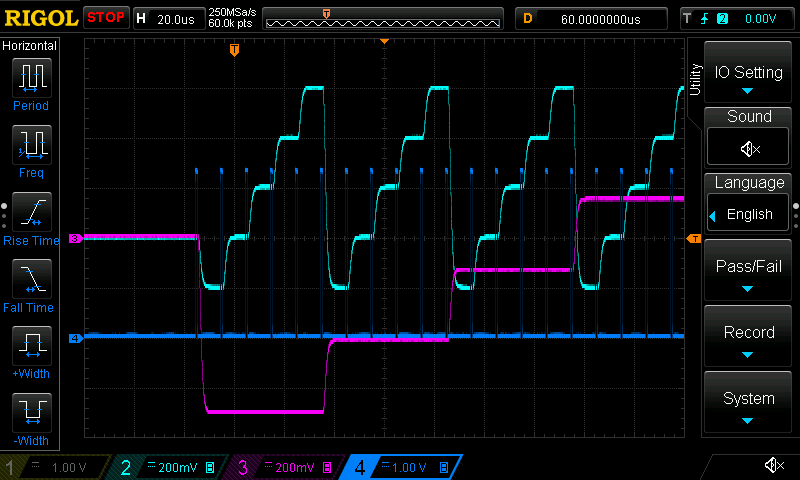

In [8]:
sleep(2)
capture()

In [8]:
print(sweep.actual_values_V('sensor1'))
print(sweep.actual_values_V('plunger2'))
print(sweep.actual_values_V('plunger3'))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.2  0.   0.2  0.4  0.6 -0.2  0.   0.2  0.4  0.6 -0.2  0.   0.2  0.4
  0.6 -0.2  0.   0.2  0.4  0.6]
[-0.7        -0.7        -0.7        -0.7        -0.7        -0.41666667
 -0.41666667 -0.41666667 -0.41666667 -0.41666667 -0.13333333 -0.13333333
 -0.13333333 -0.13333333 -0.13333333  0.15        0.15        0.15
  0.15        0.15      ]


In [9]:
# Add corrections
arrangement.initiate_correction('sensor1', [1.0, 0.1, 0.05, -0.02])
arrangement.initiate_correction('plunger2', [-0.2, 0.98, 0.3, 0.06])
arrangement.initiate_correction('plunger3', [0.01, 0.41, 1.0, 0.15])
arrangement.set_virtual_voltage('sensor1', 0.1)
arrangement.set_virtual_voltage('plunger2', 0.2)
arrangement.set_virtual_voltage('plunger3', 0.3)
sweep = arrangement.virtual_sweep2d(
        inner_gate='plunger2',
        inner_voltages=np.linspace(-0.2, 0.6, 5),
        outer_gate='plunger3',
        outer_voltages=np.linspace(-0.7, 0.15, 4),
        inner_step_time_s=10e-6,
        inner_step_trigger='dmm')

In [10]:
scope.write('sing')
sleep(4)
sweep.start()

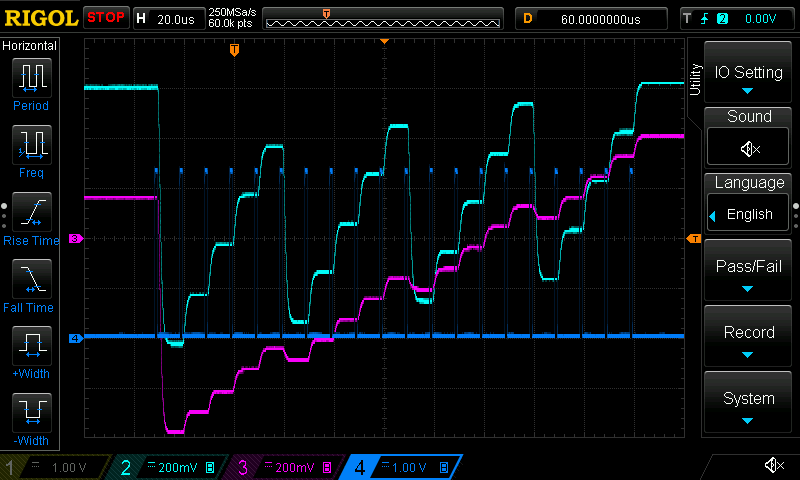

In [12]:
sleep(2)
capture()

In [11]:
print(sweep.actual_values_V('sensor1'))
print(sweep.actual_values_V('plunger2'))
print(sweep.actual_values_V('plunger3'))

[0.045      0.065      0.085      0.105      0.125      0.05916667
 0.07916667 0.09916667 0.11916667 0.13916667 0.07333333 0.09333333
 0.11333333 0.13333333 0.15333333 0.0875     0.1075     0.1275
 0.1475     0.1675    ]
[-0.426 -0.23  -0.034  0.162  0.358 -0.341 -0.145  0.051  0.247  0.443
 -0.256 -0.06   0.136  0.332  0.528 -0.171  0.025  0.221  0.417  0.613]
[-0.781      -0.699      -0.617      -0.535      -0.453      -0.49766667
 -0.41566667 -0.33366667 -0.25166667 -0.16966667 -0.21433333 -0.13233333
 -0.05033333  0.03166667  0.11366667  0.069       0.151       0.233
  0.315       0.397     ]
